In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F
from torchvision import transforms
from torchvision import models
from torch.utils.data import Dataset, DataLoader

import lightning as L

import cv2

from torchsummary import summary
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline


# Параметры

In [2]:
import warnings
warnings.filterwarnings('ignore')   #Trainer любит негодовать

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

batch_size = 4
epoch_num = 8


ab_path = "ab/ab1.npy"
L_path = "l/gray_scale.npy"
save_path = "wgan.pth"

# Вспомогательные Функции

In [3]:
def show_input_data(L, ab, index):   #не брезгуем передавать массивы, т.к. они передаются по ссылке
    plt.figure(figsize=(12, 8))

    plt.subplot(1, 2, 1)
    img = np.zeros( (224, 224, 3) )
    img[:, :, 0] = L[index]
    plt.title("Gray Scale")
    plt.imshow(img[:,:,0], cmap='gray')

    plt.axis('off')


    plt.subplot(1, 2, 2)
    img[:, :, 1:] = ab[index]
    img = img.astype('uint8')
    img_col = cv2.cvtColor(img, cv2.COLOR_LAB2RGB)
    plt.title("Colored")
    plt.imshow(img_col)

    plt.axis('off')

    plt.show()



def convert_to_Lab(L_chan, ab_chan):
    """
      т.к. при использоваии загрузчика данных значчения тензоров отображаются в сегмент [0, 1]
        необходима функция, которая уже обработанные тензоры переведёт обратно:
              L [0, 100]; a,b [-128, 127]

        (данные берутся из загрузчика и обрабатываются до конкатенации)
        (обрабатывается батч данных, это важно для указания dim=1 (это индекс) (в батче может быть и только 1 картинка))
    """
    L_chan = L_chan*100
    ab_chan = ab_chan*255 - 128   # 0->-128; 1->127
    Lab_chan = torch.cat( [L_chan, ab_chan], dim=1)
    Lab_chan = Lab_chan.permute(0, 2, 3, 1)
    Lab_chan = Lab_chan.numpy()

    return Lab_chan



def compare_result(gray, real_ab, gened_ab, ind=0):
    plt.figure(figsize=(12, 8))

    gray = gray.detach().cpu()
    real_ab = real_ab.detach().cpu()
    gened_ab = gened_ab.detach().cpu()

    real_show_b = convert_to_Lab(gray, real_ab)
    gened_show_b = convert_to_Lab(gray, gened_ab)
    gray_show = gray[ind].permute(1, 2, 0).numpy() * 100   #процесс перевода в тензор изображения меняет местами
                                                           # разрешение изображения и каналы - надо вернуть как было
                                                           # 224х224х3 -(ToTensor())-> 3x224x224 -(pretmute(...))-> 224x224x3
                                                           #   (для остальных массивов преобразование сделано в convert_to_Lab() )

    real_show = real_show_b[ind]
    gened_show = gened_show_b[ind]
    real_show = cv2.cvtColor(real_show, cv2.COLOR_LAB2RGB)
    gened_show = cv2.cvtColor(gened_show, cv2.COLOR_LAB2RGB)

    ##  Серая  ##
    plt.subplot(1, 3, 1)
    plt.title("Gray Scale")
    plt.imshow(gray_show, cmap='gray')

    plt.axis('off')


    ##  Цветная(ориг.)  ##
    plt.subplot(1, 3, 2)
    plt.title("Colored")
    plt.imshow(real_show)

    plt.axis('off')


    ##  Цветная(сген.)  ##
    plt.subplot(1, 3, 3)
    plt.title("Gened")
    plt.imshow(gened_show)

    plt.axis('off')

    plt.show()



# Загрузка данных

In [4]:
ab_data = np.load(ab_path)[0:5000]
L_data = np.load(L_path)[:5000]

In [5]:
ab_data.shape

(5000, 224, 224, 2)

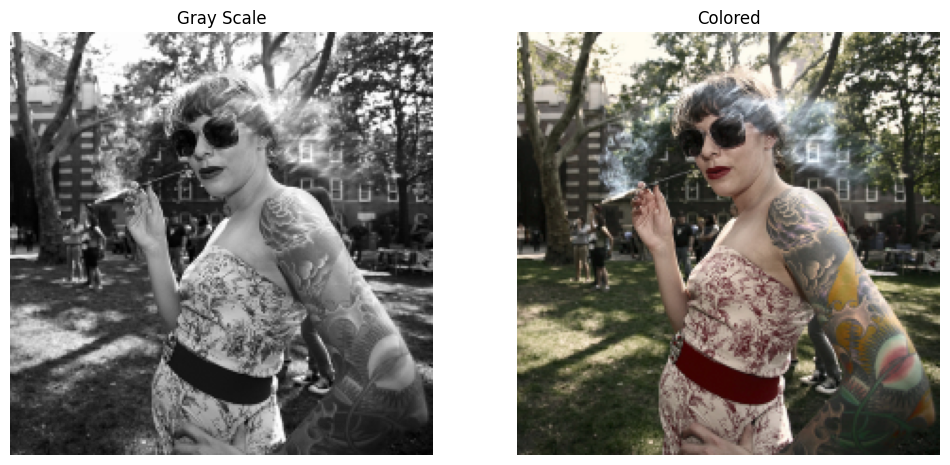

In [6]:
show_input_data(L_data, ab_data, 0)

# Создание датасета

In [7]:
class ColorizDataset(Dataset):
    def __init__(self, L_data, ab_data, transform=None):
        self.L = L_data
        self.ab = ab_data
        self.transform = transform

    def __getitem__(self, ind):
        L_ind = self.L[ind]
        L_ind = self.transform(L_ind)

        ab_ind = self.ab[ind]
        ab_ind = self.transform(ab_ind)

        return L_ind, ab_ind

    def __len__(self):
        return len(self.L)


transform = transforms.ToTensor()
dataset = ColorizDataset(L_data, ab_data, transform)

In [8]:
train_loader = DataLoader(dataset=dataset, batch_size=batch_size,
                          shuffle=True)
test_loader = DataLoader(dataset=dataset, batch_size=batch_size,
                          shuffle=False)

In [9]:
## можно проверить вид внешних данных из загрузчика:
#dataiter = iter(train_loader)
#images_gray, images_ab = next(dataiter)
#print( images_gray.shape,  images_ab.shape)
#print( torch.max(images_gray), torch.min(images_gray), torch.max(images_ab), torch.min(images_ab))
## -> значения лежат в диапазоне [0, 1]

# Создание класса Нейронной сети

## Вспомогательные функции для генератора

In [10]:
###  для генератора

class ResBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResBlock, self).__init__()

        self.block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, stride=stride, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, stride=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

        # Skipping Connection (Identity Mapping)
        self.conv_for_skip = nn.Conv2d(in_channels, out_channels, kernel_size=1, padding=0, stride=stride)

  
    def forward(self, x):
        identity = x.clone()

        x = self.block(x)
        identity = self.conv_for_skip(identity)

        output = x + identity
        output = F.relu(output)
        return output


## вниз
class UEncoder(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(UEncoder, self).__init__()

        self.down_layer = nn.Sequential(
            nn.MaxPool2d(2, 2),
            ResBlock(in_channels, out_channels, stride=stride)
        )

    def forward(self, x):
        output = self.down_layer(x)
        return output


## вверх
class UDecoder(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(UDecoder, self).__init__()

        self.upsamp = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.residual_block = ResBlock(in_channels+out_channels, out_channels)      #потому что перед Conv2d происходит конкатенация с identity (skip)
  
    def forward(self, x, skip):
        x = self.upsamp(x)

        x = torch.cat( [x, skip], dim=1)

        output = self.residual_block(x)
        return output


## Сам Генератор

In [11]:
class Generator(nn.Module):
    def __init__(self, in_channels, out_channels, dropout_rate=0.5):
        super(Generator, self).__init__()

        ## 2 первых слоя конволюции перед началом ResNet'a
        self.enc_layer0 = ResBlock(in_channels, 64)

        ## спускаемся вниз по U-Net'у
        self.enc_layer1 = UEncoder(64, 128)
        self.enc_layer2 = UEncoder(128, 256)

        ## "центральная" часть (мост)
        self.bridge = UEncoder(256, 512)

        ## возвращаемся к первоначчальным размерам
        self.dec_layer2 = UDecoder(512, 256)
        self.dec_layer1 = UDecoder(256, 128)
        self.dec_layer0 = UDecoder(128, 64)

        ## переводим необходимое нам кол-во каналов в качестве output генератора
        ##   (получили 1 канал: L; на выходе 2 канала: a,b)
        self.output = nn.Conv2d(64, out_channels, kernel_size=1, padding=0)

        # применяется после Conv2d для меньшей зависимости между каналами feature maps
        self.drop = nn.Dropout2d(dropout_rate)

  
    def forward(self, x):
        # спуск вниз
        e0 = self.enc_layer0(x)   #разные буквы, так как нам нужны skip connections
        e0 = self.drop(e0)   #skip №0
        e1 = self.enc_layer1(e0)
        e1 = self.drop(e1)   #skip №1
        e2 = self.enc_layer2(e1)
        e2 = self.drop(e2)   #skip №2

        # мостик
        b = self.bridge(e2)
        b = self.drop(b)

        # обратно
        d2 = self.dec_layer2(b, e2)
         #d2 = self.drop(d2)    возможно, при увелечении размерности, это не необходимо
        d1 = self.dec_layer1(d2,e1)
         #d1 = self.drop(d1)
        d0 = self.dec_layer0(d1, e0)

        output = self.output(d0)
        return output


In [12]:
check_model = Generator(1,2).to(device)
summary(check_model, (1, 224, 224), batch_size = 1)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [1, 64, 224, 224]             576
       BatchNorm2d-2          [1, 64, 224, 224]             128
              ReLU-3          [1, 64, 224, 224]               0
            Conv2d-4          [1, 64, 224, 224]          36,864
       BatchNorm2d-5          [1, 64, 224, 224]             128
              ReLU-6          [1, 64, 224, 224]               0
            Conv2d-7          [1, 64, 224, 224]             128
          ResBlock-8          [1, 64, 224, 224]               0
         Dropout2d-9          [1, 64, 224, 224]               0
        MaxPool2d-10          [1, 64, 112, 112]               0
           Conv2d-11         [1, 128, 112, 112]          73,728
      BatchNorm2d-12         [1, 128, 112, 112]             256
             ReLU-13         [1, 128, 112, 112]               0
           Conv2d-14         [1, 128, 1

## Критик (Дискриминатор)

In [13]:
##from torch.nn.modules.instancenorm import InstanceNorm2d
# простенькая cnn: на выходе размерность 1, чем больше число,
#   тем вероятнее, по мнению критика, что картинка настоящая (не сгенерирована)
class Critic(nn.Module):
    def __init__(self, in_channels=3):
        super(Critic, self).__init__()

        self.discrim = nn.Sequential(
            # 224x224 - размеры картинки (без feature maps)
            nn.Conv2d(in_channels, 64, kernel_size=5, stride=2, padding=0),   #110x110
            nn.LeakyReLU(0.3, inplace=True),

            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),   #55x55
            nn.InstanceNorm2d(128),
            nn.LeakyReLU(0.3, inplace=True),

            nn.Conv2d(128, 256, kernel_size=7, stride=2, padding=0),  #25x25
            nn.InstanceNorm2d(256),
            nn.LeakyReLU(0.3, inplace=True),

            nn.Conv2d(256, 512, kernel_size=5, stride=3, padding=1),  #8x8
            nn.InstanceNorm2d(512),
            nn.LeakyReLU(0.3, inplace=True),

            nn.AdaptiveAvgPool2d(1), #1x1
            nn.Flatten(),
            nn.Linear(512, 1)  #512 features maps -> 1 скалярный вывод
        )
  
  
    def forward(self, l, ab):
        x = torch.cat( (l, ab), dim=1)

        output = self.discrim(x)
        return output


In [14]:
check_model = Critic(3).to(device)
summary(check_model, [(1, 224, 224),(2, 224, 224)], batch_size = 1)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [1, 64, 110, 110]           4,864
         LeakyReLU-2          [1, 64, 110, 110]               0
            Conv2d-3           [1, 128, 55, 55]         131,200
    InstanceNorm2d-4           [1, 128, 55, 55]               0
         LeakyReLU-5           [1, 128, 55, 55]               0
            Conv2d-6           [1, 256, 25, 25]       1,605,888
    InstanceNorm2d-7           [1, 256, 25, 25]               0
         LeakyReLU-8           [1, 256, 25, 25]               0
            Conv2d-9             [1, 512, 8, 8]       3,277,312
   InstanceNorm2d-10             [1, 512, 8, 8]               0
        LeakyReLU-11             [1, 512, 8, 8]               0
AdaptiveAvgPool2d-12             [1, 512, 1, 1]               0
          Flatten-13                   [1, 512]               0
           Linear-14                   

## Воедино

In [15]:
class WGAN(L.LightningModule):
    def __init__(self, in_channels, out_channels, lr=0.001, n_critic=5, clamp_value=0.01):
        super(WGAN, self).__init__()
        self.save_hyperparameters()
        self.automatic_optimization = False

        self.generator = Generator(in_channels, out_channels, 0.2)
        self.critic = Critic(in_channels+out_channels)

        self.n_critic = n_critic
        self.clamp_value = clamp_value

        self.apply(self.custom_init_weights)

  
    def custom_init_weights(self, m):
        '''
            weights следует быть небольшими, поэтому предлагается после каждого спуска
              по градиенту переводить значения в условный отрезок [-0.01, 0.01],
            поэтому изначально нет смысла в больших значениях 
            (https://arxiv.org/pdf/1701.07875v3.pdf, стр. 7)
        '''
        if isinstance(m, (nn.Conv2d, nn.BatchNorm2d)):
            #torch.nn.init.normal_(m.weight, 0.0, 0.01)
            m.weight.data.normal_(mean=0.0, std=0.01)
            if m.bias is not None:
                m.bias.data.zero_()


    def configure_optimizers(self):
        learning_rate = self.hparams.lr

        opt_g = torch.optim.Adam(self.generator.parameters(), lr=learning_rate)
        opt_d = torch.optim.Adam(self.critic.parameters(), lr=learning_rate)
        return [opt_g, opt_d], []


    def forward(self, z):
        return self.generator(z)
  

    def training_step(self, batch, batch_idx):
        gray, real_ab = batch   #батч имеет вид: (L канал, ab канал)
        self.current_batch = [gray.detach(), real_ab.detach()]   #сохраним батч, чтобы в конце ипока нарисовать прогресс сети

        optimizer_g, optimizer_d = self.optimizers()

        ###  тренеруем Генератор  ###
         #self.toggle_optimizer(optimizer_g)

        fake_ab = self(gray)
        fake_ab = fake_ab.type_as(gray)  #если батч находится на gpu, переместим сгенерированные изображения туда же

        g_loss = -torch.mean( self.critic(gray, fake_ab) )   #берём среднее от результатов критика по генерирукмым данным со знаком минус,
                                                             #   т.к. loss изначально подразумевается к уменьшению, 
                                                             #    а правдоподобность картинки пропорциональна выводу критика => надо увеличить

        optimizer_g.zero_grad()   
        self.manual_backward(g_loss)
        optimizer_g.step()

         #self.untoggle_optimizer(optimizer_g)
        ###  конец тренеровки Генератора  ###


        ###  тренеруем Критика  ###
         #self.toggle_optimizer(optimizer_d)

        for repeats in range(self.n_critic):
            #для WGAN рекомендовано, чтобы на 1 тренировочный шаг генератора
            #   приходилось несколько шагов критика (предлагаемое знач. = 5)


            #нужно проверить два условия:
            #   1)входные real_ab помечены, как правдаподобные
            #   2)сгенерированные fake_ab помечены, как неправдаподобные
            #        (но fake_ab должны быть сгенерированы заново, т.к. генератор был немного изменён внутри training_step )
            fake_ab = self(gray).detach()   #но генератор обновляться уже не будет -> .detach()
            fake_ab = fake_ab.type_as(gray)

            real_loss = self.critic(gray, real_ab)
            fake_loss = self.critic(gray, fake_ab)

            c_loss = -( torch.mean(real_loss) - torch.mean(fake_loss) )   #и тут минус...?

            optimizer_d.zero_grad()
            self.manual_backward(c_loss)
            optimizer_d.step()

          #помещаем веса в интервал [-eps, eps], где eps - небольшое значение
          # (см. custom_init_weights  (https://arxiv.org/pdf/1701.07875v3.pdf, стр. 7) )
            for p in self.critic.parameters():  
                p.data.clamp_(-self.clamp_value, self.clamp_value)

         #self.untoggle_optimizer(optimizer_d)
        ###  конец тренеровки Критика  ###



    def on_train_epoch_end(self):
        #каждый n-ый epoch выводим
        n = 5
        torch.save(self.state_dict(), save_path)
        if ( (self.current_epoch) % n == 0):
            print(f'Epoch №{self.current_epoch}')
            gray, ab = self.current_batch
            compare_result(gray, ab, self(gray))



In [16]:
wgan = WGAN(in_channels=1, out_channels=2, lr=0.001)
#for name, param in wgan.named_parameters():
#  print(f'{name}: {param}')

# Если надо загрузить

In [17]:
#loaded_model = WGAN(in_channels=1, out_channels=2, lr=0.001)
#loaded_model.load_state_dict(torch.load(save_path))
wgan.load_state_dict(torch.load(save_path))
#wgan.train();

<All keys matched successfully>

# Тренируем

In [18]:
trainer = L.Trainer(max_epochs=epoch_num, accelerator="auto")
trainer.fit(wgan, train_loader)

# Всё посмотрели, понравилось, берём

In [20]:
torch.save(wgan.state_dict(), save_path)
#на всякий случай?
torch.save(wgan.generator.state_dict(), 'generator.pth')
torch.save(wgan.critic.state_dict(), 'critic.pth')

# Доп проверка и пр.

In [27]:
test_iter = iter(test_loader)

In [43]:
gray, real = next(test_iter)
generated = wgan(gray).detach()

In [44]:
generated.min()

tensor(0.3528)

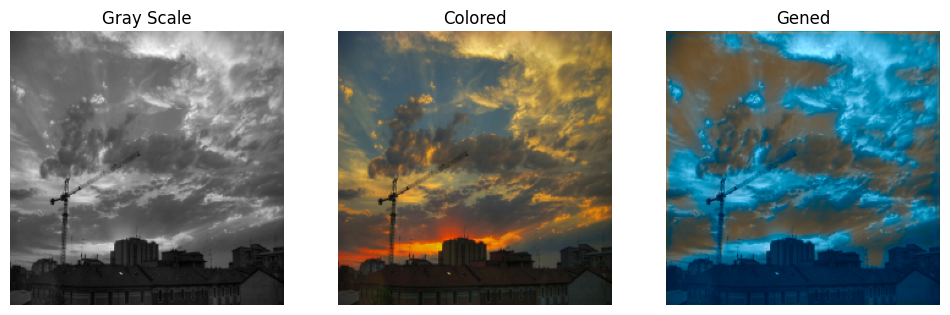

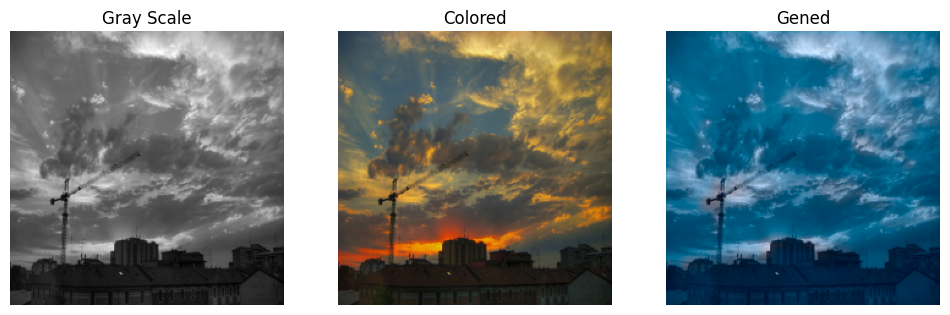

In [45]:
compare_result(gray, real, generated)
compare_result(gray, real, wgan(gray).detach())
